* https://www.springboard.com/workshops/ucsd-machine-learning-engineering-bootcamp/learn#/curriculum/26454
* https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

## A Practitioner's Guide to Natural Language Processing (Part I) — Processing & Understanding Text

### What this article covers

This article will be covering the following aspects of NLP in detail with hands-on examples.

1. Data Retrieval with Web Scraping
1. Text wrangling and pre-processing
1. Parts of Speech Tagging
1. Shallow Parsing
1. Constituency and Dependency Parsing
1. Named Entity Recognition
1. Emotion and Sentiment Analysis

### Standard NLP Workflow
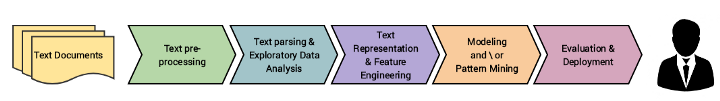

## 1. Data Retrieval with Web Scraping

### Scraping News Articles for Data Retrieval

We will be scraping [inshorts](https://inshorts.com/), the website

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

Invoke this function and build our dataset:

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Panasonic India announces new line-up of 'trul...,Panasonic India announced a new range of 'Smar...,technology
1,"The hell with it, we'll keep funding Ukraine g...",A day after saying SpaceX cannot indefinitely ...,technology
2,'Make-in-India' record-breaker: Piyush Goyal a...,Union Commerce Minister Piyush Goyal lauded th...,technology
3,Trying my hardest to de-escalate it and failin...,World's richest person Elon Musk said he's try...,technology
4,Electric car goes from zero to 100 kmph in 1.4...,An electric car in Germany has set the Guinnes...,technology
5,PM Modi dedicates 75 Digital Banking Units acr...,Prime Minister Narendra Modi on Sunday dedicat...,technology
6,Got a call saying 'hope you die': CEO after US...,US-based software company Canopy's CEO Davis B...,technology
7,What are the rates at which employees are leav...,Infosys has reported an attrition rate of 27.1...,technology
8,Figment of imagination: Capitalmind CEO on vir...,"A LinkedIn post claiming that UPI is ""killing""...",technology
9,Apple working on dock to turn iPad into smart ...,Apple is working on a new dock for the iPad wh...,technology


Check the total number of news articles:

In [4]:
news_df.news_category.value_counts()

technology    25
sports        25
world         25
Name: news_category, dtype: int64

## 2. Text wrangling and pre-processing

We will be leveraging a fair bit of **nltk** and **spacy**.

```
$ pip install spacy
$ python -m spacy download en_core_web_sm
```

We leverage a standard set of contractions available in the **contractions.py** file in my [repository](https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/nlp%20proven%20approach)

In [5]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('averaged_perceptron_tagger')
nltk.download('conll2000')
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dave/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/dave/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


In [6]:
#nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
nlp = spacy.load('en_core_web_sm')
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

**Removing HTML tags:**

In [7]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

**Removing accented characters:**

In [8]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

**Expanding Contractions:**

In [9]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

**Removing Special Characters:**

In [10]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

**Stemming**:

Word stems are also known as the **base form** or **root stem** of a word.
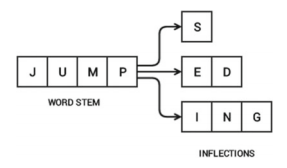
The figure shows how the word stem is present in all its inflections.

 The reverse process of obtaining the base form of a word from its inflected form is known as *stemming*. Stemming helps us in standardizing words to their base or root stem, irrespective of their inflections

In [11]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'my system keep crash hi crash yesterday, our crash daili'

>Do note that usually **stemming** has a fixed set of rules, hence, *the root stems may not be lexicographically correct*.

**Lemmatization:**

* Lemmatization is very similar to *stemming*, where we remove word affixes to get to the base form of a word.
* However, the base form in this case is known as the **root word** or the **lemma**, not the root stem.
* The difference being that the **root word is always a lexicographically correct word (present in the dictionary)**, but the *root stem* may not be so.

In [12]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'my system keep crash ! his crashed yesterday , our crash daily'

>The lemmatization process is considerably slower than stemming, because an additional step is involved where the root form or lemma is formed by removing the affix from the word if and only if the lemma is present in the dictionary.

**Removing Stopwords:**

* Words which have little or no significance
* Typically, these can be articles, conjunctions, prepositions and so on.
* Some examples of stopwords are *a*, *an*, *the*, and the like.
* There is no universal stopword list.
* We use a standard English language stopwords list from nltk.
* You can also add your own domain-specific stopwords as needed.

In [13]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

**Bringing it all together — Building a Text Normalizer:**

In [14]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

* We will first combine the news headline and the news article text together to form a document for each piece of news.
* Then, we will pre-process them.

In [15]:
# combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': 'The hell with it, we\'ll keep funding Ukraine govt despite Starlink losing money: Musk. A day after saying SpaceX cannot indefinitely fund its Starlink service in Ukraine, billionaire Elon Musk on Saturday said it will continue to do the same. "The hell with it...even though Starlink is still losing money and other companies are getting billions of taxpayer dollars, we\'ll just keep funding Ukraine govt for free," tweeted Musk. ',
 'clean_text': 'hell keep fund ukraine govt despite starlink lose money musk day say spacex not indefinitely fund starlink service ukraine billionaire elon musk saturday say continue hell even though starlink still lose money company get billion taxpayer dollar keep fund ukraine govt free tweet musk'}

* Our text pre-processor helps in pre-processing our news articles.
* You can save this dataset to disk if needed for future analysis.

In [16]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

## 3. Parts of Speech Tagging

Parts of speech (**POS**) are specific lexical categories to which words are assigned, based on their syntactic context and role.

Usually, words can fall into one of the following major categories:

* **N(oun)**: Usually denotes words that depict some object or entity, which may be living or nonliving. Some examples would be *fox* , *dog* , *book* , and so on. The **POS** tag symbol for nouns is **N**.
* **V(erb)**: Verbs are words that are used to describe certain actions, states, or occurrences. There are a wide variety of further subcategories, such as auxiliary, reflexive, and transitive verbs (and many more). Some typical examples of verbs would be *running*, *jumping*, *read*, and *write*. The **POS** tag symbol for verbs is **V**.
* **Adj(ective)**: Adjectives are words used to describe or qualify other words, typically nouns and noun phrases. The phrase *beautiful flower* has the noun (N) flower which is described or qualified using the adjective (ADJ) *beautiful*. The **POS** tag symbol for adjectives is **ADJ**.
* **Adv(erb)**: Adverbs usually act as modifiers for other words including nouns, adjectives, verbs, or other adverbs. The phrase *very beautiful flower* has the adverb (ADV) *very* , which modifies the adjective (ADJ) beautiful , indicating the degree to which the flower is beautiful. The **POS** tag symbol for adverbs is **ADV**.

Helpful to perform specific analysis, such as:
* narrowing down upon nouns and seeing which ones are the most prominent
* word sense disambiguation
* grammar analysis

We will be leveraging both **nltk** and **spacy**.

In [17]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,The,DT,DET
1,hell,NN,NOUN
2,with,IN,ADP
3,it,PRP,PRON
4,",",",",PUNCT
5,we,PRP,PRON
6,'ll,MD,AUX
7,keep,VB,VERB
8,funding,VBG,VERB
9,Ukraine,NNP,PROPN


In [18]:
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,The,DT
1,hell,NN
2,with,IN
3,"it,",JJ
4,we'll,NN
5,keep,VB
6,funding,NN
7,Ukraine,NNP
8,govt,NN
9,despite,IN


We can see that each of these libraries treat tokens in their own way and assign specific tags for them. Based on what we see, `spacy` seems to be doing slightly better than `nltk`.

## 4. Shallow Parsing

#### Shallow Parsing or Chunking

Groups of words make up phrases. There are five major categories of phrases:

* **Noun phrase (NP)**: These are phrases where a *noun acts as the head word*. Noun phrases act as a subject or object to a verb.
* **Verb phrase (VP)**: These phrases are lexical units that have a *verb acting as the head word*. Usually, there are two forms of verb phrases. One form has the verb components as well as other entities such as nouns, adjectives, or adverbs as parts of the object.
* **Adjective phrase (ADJP)**: These are phrases with an *adjective as the head word*. Their main role is to describe or qualify nouns and pronouns in a sentence, and they will be either placed before or after the noun or pronoun.
* **Adverb phrase (ADVP)**: These phrases act like adverbs since the *adverb acts as the head word* in the phrase. Adverb phrases are used as modifiers for nouns, verbs, or adverbs themselves by providing further details that describe or qualify them.
* **Prepositional phrase (PP)**: These phrases usually contain a *preposition as the head word* and other lexical components like nouns, pronouns, and so on. These act like an adjective or adverb describing other words or phrases.

**Shallow parsing**, also known as **light parsing** or **chunking**, is a popular natural language processing technique of analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. This includes POS tags as well as phrases from a sentence.
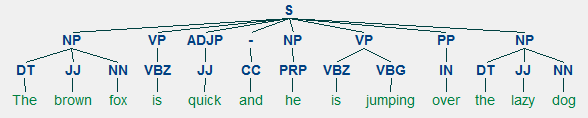

In [19]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


From the preceding output, you can see that our data points are sentences that are already **annotated with phrases** and **POS tags metadata** that will be useful in training our **shallow parser model**.

We will leverage two chunking utility functions:
* **tree2conlltags**, to get triples of word, tag, and chunk tags for each token
* **conlltags2tree** to generate a parse tree from these token triples.

We will be using these functions to train our parser. A sample is depicted below:

In [20]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

The **chunk tags** use the **IOB format**. This notation represents **Inside**, **Outside, and **Beginning**:
* The **B- prefix** before a tag indicates it is the **beginning of a chunk**
* The **I- prefix** indicates that it is **inside a chunk**.
* The **O tag** indicates that the token does not belong to any chunk.
* The **B- tag** is always used when there are subsequent tags of the same type following it without the presence of O tags between them.

Define a function **conll_tag_ chunks()** to extract POS and chunk tags from sentences with chunked annotations.

Define a function called **combined_taggers()** to train multiple taggers with backoff taggers (e.g. unigram and bigram taggers)

In [21]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

Define a class NGramTagChunker that will:
* take in tagged sentences as training input
* get their (word, POS tag, Chunk tag) WTC triples

Train a **BigramTagger** with a **UnigramTagger** as the **backoff tagger**.

We will also define a *parse()* function to perform shallow parsing on new sentences.

>The **UnigramTagger**, **BigramTagger**, and **TrigramTagger** are classes that inherit from the base class **NGramTagger**, which itself inherits from the **ContextTagger class**, which inherits from the **SequentialBackoffTagger class**.

We will use this class to train on the *conll2000* chunked train_data and evaluate the model performance on the test_data.

In [22]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


/tmp/ipykernel_1740105/1209335263.py:26: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print(ntc.evaluate(test_data))


Our chunking model gets an accuracy of around 90% which is quite good.

Let’s now leverage this model to shallow parse and chunk our sample news article 
headline which we used earlier, *“US unveils world’s most powerful supercomputer, beats China”*.

In [23]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP The/DT hell/NN)
  (PP with/IN)
  (NP it,/JJ we'll/NN)
  (VP keep/VB)
  (NP funding/NN Ukraine/NNP govt/NN)
  (PP despite/IN)
  (NP Starlink/NNP losing/VBG money:/NN Musk/NNP))


Thus you can see it has identified two **noun phrases (NP)** and one **verb phrase (VP)** in the news article. Each word’s POS tags are also visible. We can also visualize this in the form of a tree as follows. You might need to install ghostscript in case nltk throws an error.

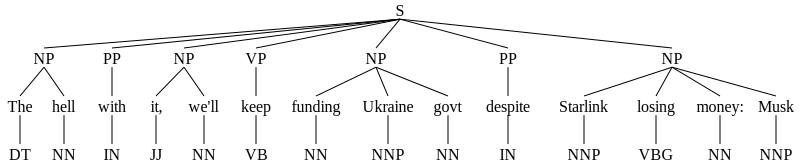

In [24]:
from IPython.display import display

display(chunk_tree)

This output gives a good sense of structure after shallow parsing the news headline.

## 5. Constituency and Dependency Parsing

### Constituency Parsing

**Constituent-based grammars** are used to analyze and determine the constituents of a sentence.

These grammars can be used to model or represent the internal structure of sentences in terms of a hierarchically ordered structure of their constituents.

Each and every word usually belongs to a specific lexical category in the case and forms the head word of different phrases. These phrases are formed based on rules called **phrase structure rules**.

***Phrase structure rules* form the core of constituency grammars**, because they talk about syntax and rules that govern the hierarchy and ordering of the various constituents in the sentences. These rules cater to two things primarily:

* They determine what words are used to construct the phrases or constituents.
* They determine how we need to order these constituents together.


The generic representation of a phrase structure rule is **S → AB**, which depicts that the structure **S** consists of constituents **A** and **B** , and the ordering is **A** followed by **B**.

While there are several rules (refer to Chapter 1, Page 19: Text Analytics with Python, if you want to dive deeper), *the most important rule describes how to divide a sentence or a clause*.

The phrase structure rule denotes a binary division for a sentence or a clause as **S → NP VP** where **S** is the *sentence* or *clause*, and it is divided into the *subject*, denoted by the noun phrase (NP) and the *predicate*, denoted by the verb phrase (VP).

A **constituency parser** can be built based on such grammars/rules, which are usually collectively available as ***context-free grammar (CFG)*** or ***phrase-structured grammar***. The parser will process input sentences according to these rules, and help in building a parse tree.
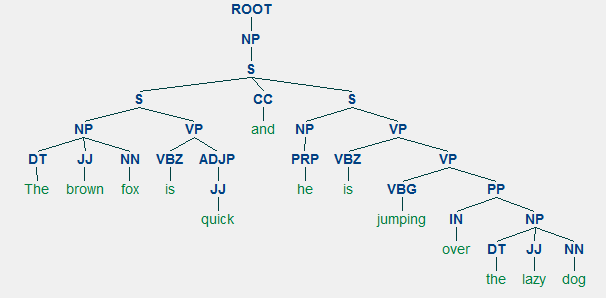

We will be using `nltk` and the `StanfordParser` here to generate parse trees.

The **Stanford parser** generally uses a **PCFG (probabilistic context-free grammar)** parser.

A PCFG is a context-free grammar that associates a probability with each of its production rules.

The probability of a parse tree generated from a PCFG is simply the production of the individual probabilities of the productions used to generate it.

In [25]:
# set java path
import os
java_path = r'/usr/bin/java'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='/home/dave/install/stanford.edu/StanfordParser/stanford-parser-full-2020-11-17/stanford-parser.jar',
                     path_to_models_jar='/home/dave/install/stanford.edu/StanfordParser/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

/tmp/ipykernel_1740105/2377517438.py:8: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  scp = StanfordParser(path_to_jar='/home/dave/install/stanford.edu/StanfordParser/stanford-parser-full-2020-11-17/stanford-parser.jar',


(ROOT
  (FRAG
    (NP
      (NP (NP (DT The) (NN hell)) (PP (IN with) (NP (PRP it))))
      (, ,)
      (SBAR
        (S
          (NP (PRP we))
          (VP
            (MD 'll)
            (VP
              (VB keep)
              (S
                (VP
                  (VBG funding)
                  (S
                    (NP (NNP Ukraine))
                    (ADJP
                      (JJ govt)
                      (PP (IN despite) (NP (NNP Starlink))))
                    (S (VP (VBG losing) (NP (NN money))))))))))))
    (: :)
    (NP (NN Musk))))


We can see the constituency parse tree for our news headline.

Let’s visualize it to understand the structure better:

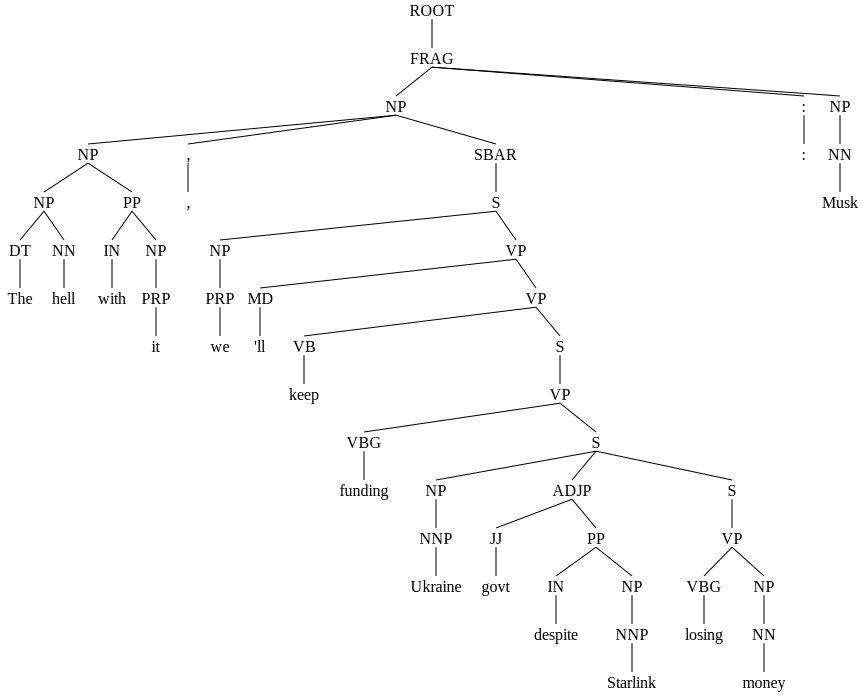

In [26]:
from IPython.display import display
display(result[0])

We can see the nested hierarchical structure of the constituents in the preceding output as compared to the flat structure in shallow parsing. In case you are wondering what **SINV** means, it represents an **Inverted declarative sentence**, i.e. one in which the subject follows the tensed verb or modal. Refer to the **Penn Treebank reference** as needed to lookup other tags.

### Dependency Parsing

In dependency parsing, we try to use dependency-based grammars to analyze and infer both *structure* and *semantic dependencies* and relationships between tokens in a sentence.

The basic principle behind a **dependency grammar** is that in any sentence in the language, all words except one, have some relationship or dependency on other words in the sentence.

The word that has no dependency is called the **root of the sentence**. The verb is taken as the root of the sentence in most cases. All the other words are directly or indirectly linked to the root verb using links, which are the dependencies.

Considering our sentence ***“The brown fox is quick and he is jumping over the lazy dog”***.

If we wanted to draw the dependency syntax tree for this, we would have the structure:
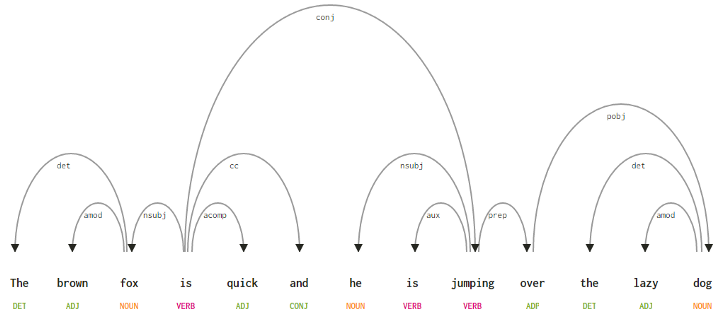

These dependency relationships each have their own meaning and are a part of a list of universal dependency types. This is discussed in an original paper, [Universal Stanford Dependencies: A Cross-Linguistic Typology by de Marneffe et al, 2014)](https://nlp.stanford.edu/pubs/USD_LREC14_paper_camera_ready.pdf).

You can check out the exhaustive list of dependency types and their meanings [here](http://universaldependencies.org/u/dep/index.html).

If we observe some of these dependencies, it is not too hard to understand them.

* The dependency tag **det** is pretty intuitive — it denotes the determiner relationship between a nominal head and the determiner. Usually, the word with POS tag DET will also have the det dependency tag relation. Examples include **fox → the and dog → the**.
* The dependency tag **amod** stands for adjectival modifier and stands for any adjective that modifies the meaning of a noun. Examples include **fox → brown and dog → lazy**.
* The dependency tag **nsubj** stands for an entity that acts as a subject or agent in a clause. Examples include **is → fox and jumping → he**.
* The dependencies **cc** and **conj** have more to do with linkages related to words connected by coordinating conjunctions . Examples include **is → and and is → jumping**.
* The dependency tag **aux** indicates the auxiliary or secondary verb in the clause. Example: jumping → is.
* The dependency tag **acomp** stands for adjective complement and acts as the complement or object to a verb in the sentence. Example: **is → quick**.
* The dependency tag **prep** denotes a prepositional modifier, which usually modifies the meaning of a noun, verb, adjective, or preposition. Usually, this representation is used for prepositions having a noun or noun phrase complement. Example: **jumping → over**.
* The dependency tag **pobj** is used to denote the object of a preposition . This is usually the head of a noun phrase following a preposition in the sentence. Example: **over → dog**.

***Spacy*** had two types of English dependency parsers based on what language models you use, you can find more details [here](https://spacy.io/api/annotation#section-dependency-parsing). Based on language models, you can use the [Universal Dependencies Scheme](http://universaldependencies.org/u/dep/index.html) or the [CLEAR Style Dependency Scheme](http://www.mathcs.emory.edu/~choi/doc/cu-2012-choi.pdf) also available in [NLP4J](https://emorynlp.github.io/nlp4j/components/dependency-parsing.html) now. We will now leverage `spacy` and print out the dependencies for each token in our news headline.

In [27]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---The[det]--->[]
--------
['The']<---hell[npadvmod]--->['with']
--------
[]<---with[prep]--->['it']
--------
[]<---it[pobj]--->[]
--------
[]<---,[punct]--->[]
--------
[]<---we[nsubj]--->[]
--------
[]<---'ll[aux]--->[]
--------
['hell', ',', 'we', "'ll"]<---keep[ROOT]--->['funding', 'despite', ':', 'Musk']
--------
[]<---funding[xcomp]--->['govt']
--------
[]<---Ukraine[compound]--->[]
--------
['Ukraine']<---govt[dobj]--->[]
--------
[]<---despite[prep]--->['losing']
--------
[]<---Starlink[nsubj]--->[]
--------
['Starlink']<---losing[pcomp]--->['money']
--------
[]<---money[dobj]--->[]
--------
[]<---:[punct]--->[]
--------
[]<---Musk[npadvmod]--->[]
--------


It is evident that the verb beats is the `ROOT` since it doesn’t have any other dependencies as compared to the other tokens. For knowing more about each annotation you can always refer to the [CLEAR dependency scheme](https://emorynlp.github.io/nlp4j/components/dependency-parsing.html). We can also visualize the above dependencies in a better way.

In [28]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

You can also leverage `nltk` and the `StanfordDependencyParser` to visualize and build out the dependency tree.

We showcase the dependency tree both in its raw and annotated form as follows:

/tmp/ipykernel_1740105/1958327807.py:2: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  sdp = StanfordDependencyParser(path_to_jar='/home/dave/install/stanford.edu/StanfordParser/stanford-parser-full-2020-11-17/stanford-parser.jar',


(hell
  The
  (it with)
  (keep
    we
    'll
    (funding (losing Ukraine (govt (Starlink despite)) money)))
  Musk)


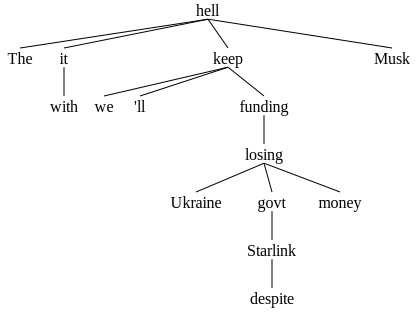

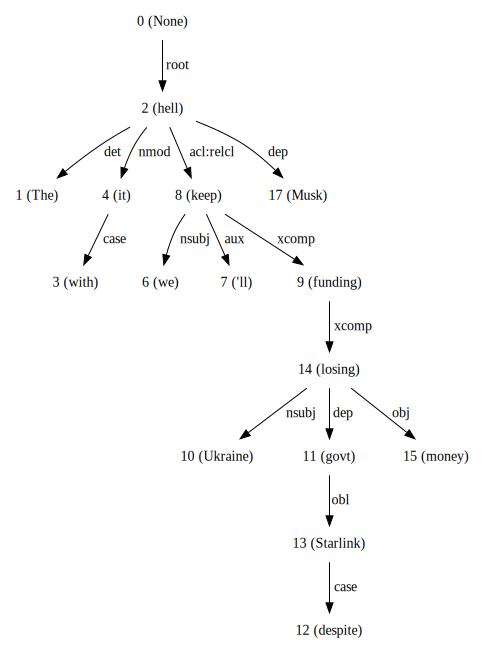

In [29]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='/home/dave/install/stanford.edu/StanfordParser/stanford-parser-full-2020-11-17/stanford-parser.jar',
                     path_to_models_jar='/home/dave/install/stanford.edu/StanfordParser/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar')

result = list(sdp.raw_parse(sentence))  

# print the dependency tree
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

# visualize raw dependency tree
from IPython.display import display
display(dep_tree)

# visualize annotated dependency tree (needs graphviz)
from graphviz import Source
dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
source

Above image: Dependency Tree visualizations using nltk’s Stanford dependency parser.

You can notice the similarities with the tree we had obtained earlier. The annotations help with understanding the type of dependency among the different tokens.

## 6. Named Entity Recognition

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. These entities are known as **named entities**, which more specifically refer to terms that represent real-world objects like people, places, organizations, and so on, which are often denoted by proper names.

A naive approach could be to find these by looking at the noun phrases in text documents.

**Named entity recognition (NER)**, also known as **entity chunking/extraction**, is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.

SpaCy has some excellent capabilities for named entity recognition. Let’s try and use it on one of our sample news articles.

In [30]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Ukraine, 'GPE'), (Musk, 'PERSON'), (A, 'DATE'), (day, 'DATE'), (Ukraine, 'GPE'), (Elon, 'PERSON'), (Musk, 'PERSON'), (Saturday, 'DATE'), (Ukraine, 'GPE'), (Musk, 'PERSON')]


We can clearly see that the major named entities have been identified by `spacy`. To understand more in detail about what each named entity means, you can refer to [the documentation](https://spacy.io/api/annotation#named-entities) or check out the following table for convenience.
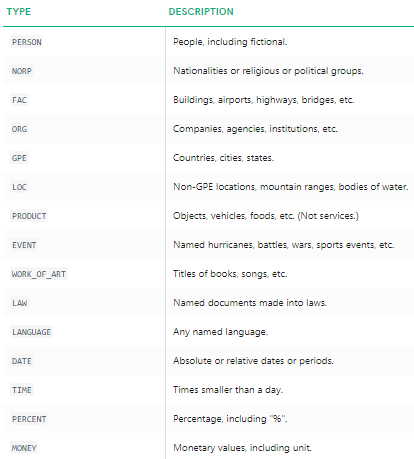

Let’s now find out the most frequent named entities in our news corpus.

For this, we will build out a **data frame** of all the **named entities** and their **types**:

In [31]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can now transform and aggregate this data frame to find the top occuring entities and types:

In [32]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,Ukraine,India,Sunday,Russia,Russian,Musk,China,World Cup,Joe Biden,1,Indian,Saturday,2022,Biden
Entity Type,GPE,GPE,GPE,DATE,GPE,NORP,PERSON,GPE,EVENT,PERSON,CARDINAL,NORP,DATE,DATE,PERSON
Frequency,24,23,19,8,8,7,6,6,5,5,5,5,5,4,4


We can also group by the entity types to get a sense of what types of entites occur most in our news corpus:

In [33]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,GPE,PERSON,ORG,DATE,CARDINAL,NORP,ORDINAL,EVENT,TIME,MONEY,PRODUCT,LOC,PERCENT,FAC,QUANTITY
Frequency,158,143,113,86,70,42,21,14,12,6,5,4,4,3,3


We can see that people, places and organizations are the most mentioned entities though interestingly we also have many other entities.

Another nice NER tagger is the `StanfordNERTagger` available from the `nltk` interface. For this, you need to have Java installed and then download the [Stanford NER resources](http://nlp.stanford.edu/software/stanford-ner-2014-08-27.zip).

[Stanford’s Named Entity Recognizer](https://nlp.stanford.edu/software/CRF-NER.shtml) is based on an implementation of linear chain Conditional Random Field (CRF) sequence models.

Unfortunately this model is only trained on instances of PERSON, ORGANIZATION and LOCATION types.

The eollowing code can be used as a standard workflow which helps us extract the named entities using this tagger and show the top named entities and their types (extraction differs slightly from `spacy`):

In [34]:
from nltk.tag import StanfordNERTagger
import os

# set java path
java_path = r'/usr/bin/java'
os.environ['JAVAHOME'] = java_path

# initialize NER tagger
sn = StanfordNERTagger('/home/dave/install/stanford.edu/StanfordNER/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='/home/dave/install/stanford.edu/StanfordNER/stanford-ner-2020-11-17/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])
                            

# view top entities and types
#top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
#                           .size()
#                           .sort_values(ascending=False)
#                           .reset_index().rename(columns={0 : 'Frequency'}))
#top_entities.head(15)


# view top entity types
#top_entities = (entity_frame.groupby(by=['Entity Type'])
#                           .size()
#                           .sort_values(ascending=False)
#                           .reset_index().rename(columns={0 : 'Frequency'}))
#top_entities.head()

In [35]:
# view top entities and types
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,Ukraine,LOCATION,22
1,US,LOCATION,19
2,India,LOCATION,16
3,China,LOCATION,7
4,Russia,LOCATION,7
5,Starlink,ORGANIZATION,7
6,Rohit,PERSON,6
7,Namibia,LOCATION,6
8,SpaceX,ORGANIZATION,6
9,Sri Lanka,LOCATION,5


In [36]:
# view top entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,LOCATION,164
1,PERSON,150
2,ORGANIZATION,119


## 7. Emotion and Sentiment Analysis

Sentiment analysis is perhaps one of the most popular applications of NLP.

Typically, we quantify this sentiment with a *positive* or *negative* value, called **polarity**. The *overall sentiment* is often inferred as *positive*, *neutral* or *negative* from the sign of the **polarity score**.

Usually, sentiment analysis works best on text that has a *subjective context* than on text with only an *objective context*.

Typically, sentiment analysis for text data can be computed on several levels, including on an *individual sentence level*, *paragraph level*, or the *entire document* as a whole.

There are two major approaches to sentiment analysis:
* Supervised machine learning or deep learning approaches
* Unsupervised lexicon-based approaches

For the first approach we typically need pre-labeled data.

**Hence, we will be focusing on the second approach**.

We will need to use unsupervised techniques for predicting the sentiment by using knowledgebases, ontologies, databases, and lexicons that have detailed information, specially curated and prepared just for sentiment analysis.

A **lexicon** is a dictionary, vocabulary, or a book of words.

In our case, lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.

Most of these lexicons have a list of *positive* and *negative* **polar words** with some *score* associated with them, and using various techniques like the position of words, surrounding words, context, parts of speech, phrases, and so on, scores are assigned to the text documents for which we want to compute the sentiment.

After aggregating these scores, we get the **final sentiment**.

Various popular lexicons are used for sentiment analysis, including the following.

* AFINN lexicon
* Bing Liu’s lexicon
* MPQA subjectivity lexicon
* SentiWordNet
* VADER lexicon
* TextBlob lexicon

### Sentiment Analysis with AFINN Lexicon

The **AFINN lexicon** is perhaps one of the simplest and most popular lexicons that can be used extensively for sentiment analysis.

Developed and curated by Finn Årup Nielsen, you can find more details on this lexicon in the paper, “A new ANEW: evaluation of a word list for sentiment analysis in microblogs”, proceedings of the ESWC 2011 Workshop. The current version of the lexicon is AFINN-en-165. txt and it contains over 3,300+ words with **a polarity score associated with each word**.

You can find this lexicon at the author’s official GitHub repository along with previous versions of it, including AFINN-111. The author has also created a nice wrapper library on top of this in Python called `afinn`, which we will be using for our analysis.

The following code computes sentiment for all our news articles and shows summary statistics of general sentiment per news category:

In [38]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                            
                        count  mean       std   min   25%  50%  75%   max
news_category                                                            
sports                   25.0  4.12  6.912067  -9.0   0.0  3.0  9.0  19.0
technology               25.0 -1.20  6.487167 -21.0  -6.0  2.0  3.0   7.0
world                    25.0 -7.24  9.566783 -30.0 -11.0 -7.0  0.0  11.0

We can get a good idea of general sentiment statistics across different news categories. Let’s look at some visualizations now.

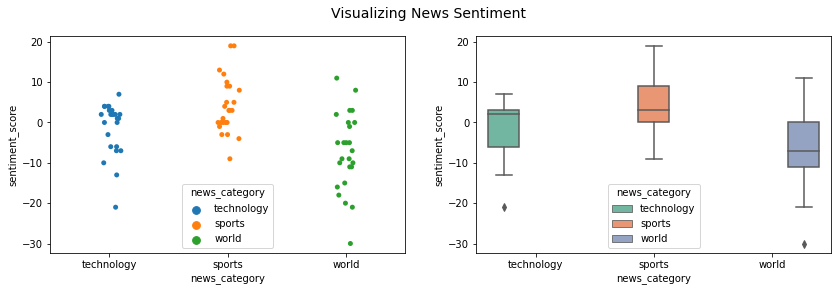

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

We can also visualize the frequency of sentiment labels.

/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


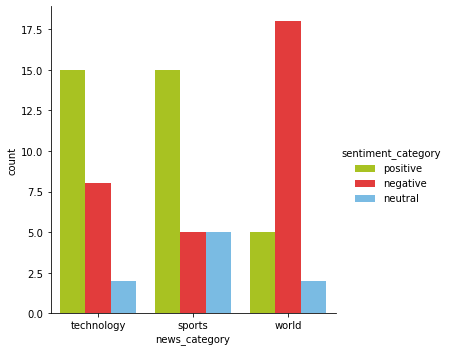

In [40]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [44]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 11)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -30)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Four prisoners were killed and 61 others were injured in the fire that broke out at Tehran's Evin prison on Saturday, Iranian authorities said on Sunday. According to authorities, the fire started after a prison workshop was set ablaze following "a fight among a number of prisoners". Evin reportedly holds many detainees facing security charges, including Iranians with dual nationality.

Most Positive World News Article: Over 1,000 Paddington bears and other teddy bears left as a tribute to the late Queen Elizabeth II will be donated to a children's charity, Buckingham Palace said on Saturday. The Queen was linked to the children's literary character Paddington after they both appeared in a video together during Platinum Jubilee celebrations to mark her 70 years of service.


Let’s dive deeper into the most positive and negative sentiment news articles for technology news:

In [45]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 7)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -21)].index[0]

print('Most Negative Technology News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Technology News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Technology News Article: World's richest person Elon Musk said he's trying his "hardest to de-escalate" Ukraine-Russia situation and "obviously failing". His response came to a Twitter user accusing him of continuing support for "US proxy war" in Ukraine after Musk said SpaceX will provide Starlink in Ukraine despite losing money. "Damned if you do, damned if you don't, so...I'm just damned," Musk wrote.

Most Positive Technology News Article: Apple is working on a new dock for the iPad which will allow it to function as smart display and a speaker, according to a report. It is looking to make the tablet similar to an Amazon Echo Show-like device that can be put atop a counter, the report added. The docking station will allow hands-free management of home devices.


### Sentiment Analysis with TextBlob

**TextBlob** is another excellent open-source library for performing NLP tasks with ease, including **sentiment analysis**. It also an a **sentiment lexicon** (in the form of an XML file) which it leverages to give both polarity and subjectivity scores. 

Typically, the scores have a normalized scale as compare to **Afinn**.

The polarity score is a float within the range `[-1.0, 1.0]`. The subjectivity is a float within the range `[0.0, 1.0]` where `0.0` is very objective and `1.0` is very subjective.

Let’s use this now to get the sentiment polarity and labels for each news article and aggregate the summary statistics per news category:

In [47]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()
                                     

sentiment_score                                                \
                        count     mean       std   min    25%    50%    75%   
news_category                                                                 
sports                   25.0  0.26324  0.297622 -0.40  0.069  0.258  0.400   
technology               25.0  0.05512  0.152637 -0.35  0.000  0.062  0.144   
world                    25.0 -0.01072  0.162257 -0.40 -0.100  0.000  0.100   

                      
                 max  
news_category         
sports         0.800  
technology     0.400  
world          0.251

Let’s look at the sentiment frequency distribution per news category:

/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


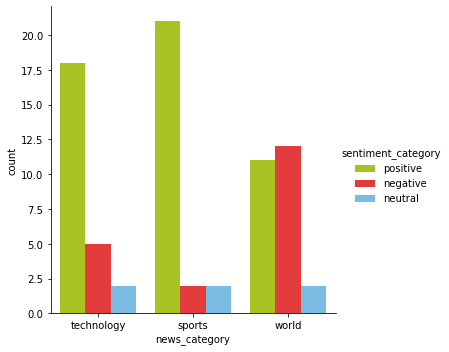

In [48]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

There definitely seems to be more positive articles across the news categories here as compared to our previous model.

Let’s now do a comparative analysis and see if we still get similar articles in the most positive and negative categories for world news:

In [49]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.251)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.40)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: US and Canada on Saturday delivered security equipment like tactical and armoured vehicles and supplies to Haiti, according to a joint statement. "This equipment will assist the [Haitian National Police] in their fight against criminal actors who're fomenting violence and disrupting the flow of...humanitarian assistance, hindering efforts to halt the spread of cholera," the joint statement said.

Most Positive World News Article: Russia is using rape and sexual assault as a "strategy" in Ukraine, a UN official said in an interview. "When you hear women testify about Russian soldiers equipped with Viagra, it's clearly a military strategy," said UN special representative on sexual violence in conflict, Pramila Patten. UN verified over 100 rape cases in Ukraine since the war began, she added.


Finally, we can even **evaluate and compare between these two models** as to how many predictions are matching and how many are not (by leveraging a confusion matrix which is often used in classification).

We leverage our `model_evaluation_utils` module for this:

In [ ]:
import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])